# Classic Methods

In [17]:
GOOGLE = False
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')

## Imports

In [18]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

## Data Loading

In [40]:
import numpy as np
if GOOGLE:

    path_prefix = "/content/drive/MyData/project_data/project/"
    

X_test_original = np.load(path_prefix+"X_test.npy")
y_test_original = np.load(path_prefix+"y_test.npy")
person_train_valid_original = np.load(path_prefix+"person_train_valid.npy")
X_train_valid_original = np.load(path_prefix+"X_train_valid.npy")
y_train_valid_original = np.load(path_prefix+"y_train_valid.npy")
person_test_original = np.load(path_prefix+"person_test.npy")


### Shape of data

In [20]:
print ('Training/Valid data shape: {}'.format(X_train_valid_original.shape))
print ('Test data shape: {}'.format(X_test_original.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid_original.shape))
print ('Test target shape: {}'.format(y_test_original.shape))
print ('Person train/valid shape: {}'.format(person_train_valid_original.shape))
print ('Person test shape: {}'.format(person_test_original.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Helper Functions

In [50]:
## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

def get_data_by_label(label, ch_data, y_train_valid, random_count):
    class_ind = np.where(y_train_valid == label)
    ch_data_class = ch_data[class_ind]
    avg_ch_data_class = np.mean(ch_data_class,axis=0)
    rand_ch_data_class = ch_data_class[np.random.choice(len(ch_data_class), random_count)]
    return [avg_ch_data_class, rand_ch_data_class]



def extract_channel_mean(X_train_valid_original,y_train_valid, channel,random_count):
    ch_data = X_train_valid_original[:,channel,:]
    res0 = get_data_by_label(0, ch_data=ch_data, y_train_valid=y_train_valid, random_count=random_count)
    res1 =get_data_by_label(1, ch_data=ch_data, y_train_valid=y_train_valid, random_count=random_count) 
    res2 =get_data_by_label(2, ch_data=ch_data, y_train_valid=y_train_valid, random_count=random_count) 
    res3 =get_data_by_label(3, ch_data=ch_data, y_train_valid=y_train_valid, random_count=random_count)  

    return [res0, res1, res2, res3]


In [11]:
import warnings
warnings.filterwarnings('ignore')

### Filtering function

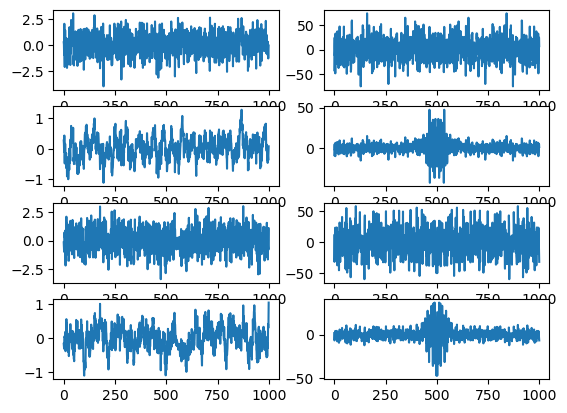

In [25]:
import numpy as np
from scipy import signal
from scipy.fft import *

def scale_high_freq(input_signal, cutoff_frequency, factor):
    # Design a high-pass filter
    b, a = signal.butter(4, cutoff_frequency, 'high')

    # Apply the high-pass filter
    highpass_filtered_signal = signal.filtfilt(b, a, input_signal)

    # Scale the amplitude of the high-pass filtered signal
    scaled_highpass_signal = highpass_filtered_signal * factor

    # Combine the scaled high-pass signal with the original signal
    output_signal = input_signal - highpass_filtered_signal + scaled_highpass_signal

    return output_signal

# Example usage
# Define your input signal, cutoff frequency, and scaling factor
input_signal = np.random.randn(2, 1000)  # Example input signal
cutoff_frequency = 0.1  # Example cutoff frequency
scaling_factor = 0.2  # Example scaling factor

# Apply the scaling filter
output_signal = scale_high_freq(input_signal, cutoff_frequency, scaling_factor)
plotter = lambda z, y : plt.subplot(z).plot(y)
plotter(421, input_signal[0]) # Random signal
plotter(422, fftshift(fft(input_signal[0]))) # fft
plotter(423, output_signal[0]) # filtered training
plotter(424, fftshift(fft(output_signal[0]))) # filtered training fft
plotter(425, input_signal[1]) # Random signal
plotter(426, fftshift(fft(input_signal[1])))
plotter(427, output_signal[1])
plotter(428, fftshift(fft(output_signal[1])))

## Filtering test data so its closer to training data

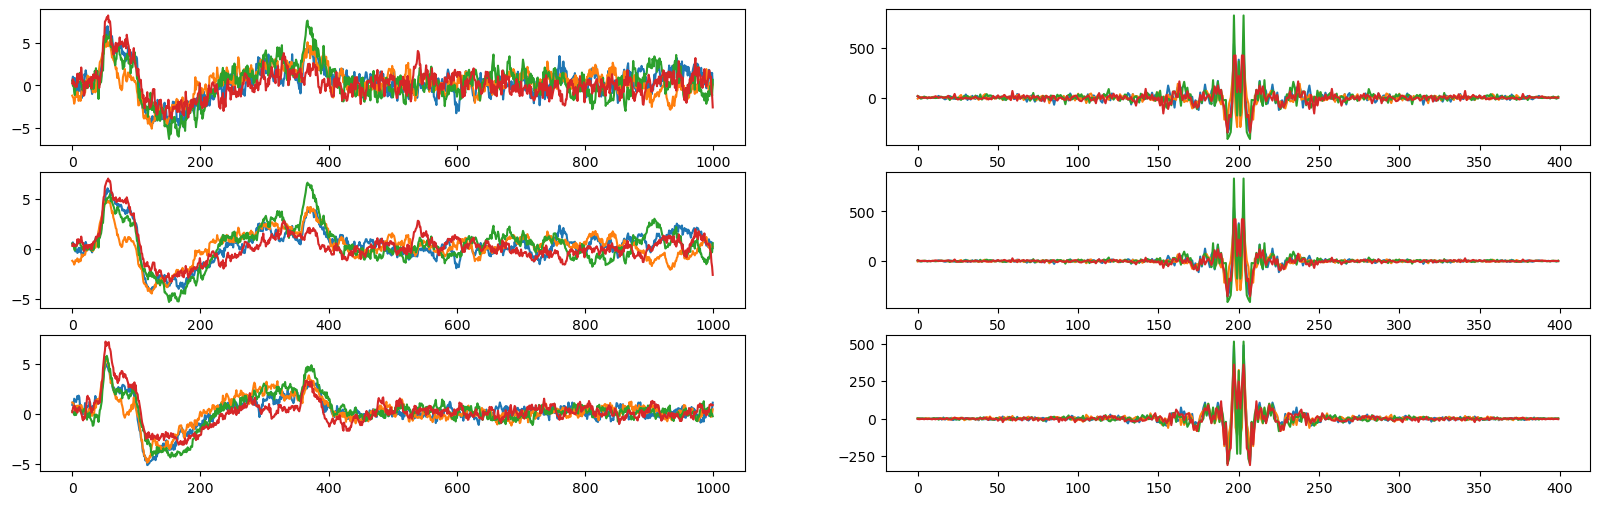

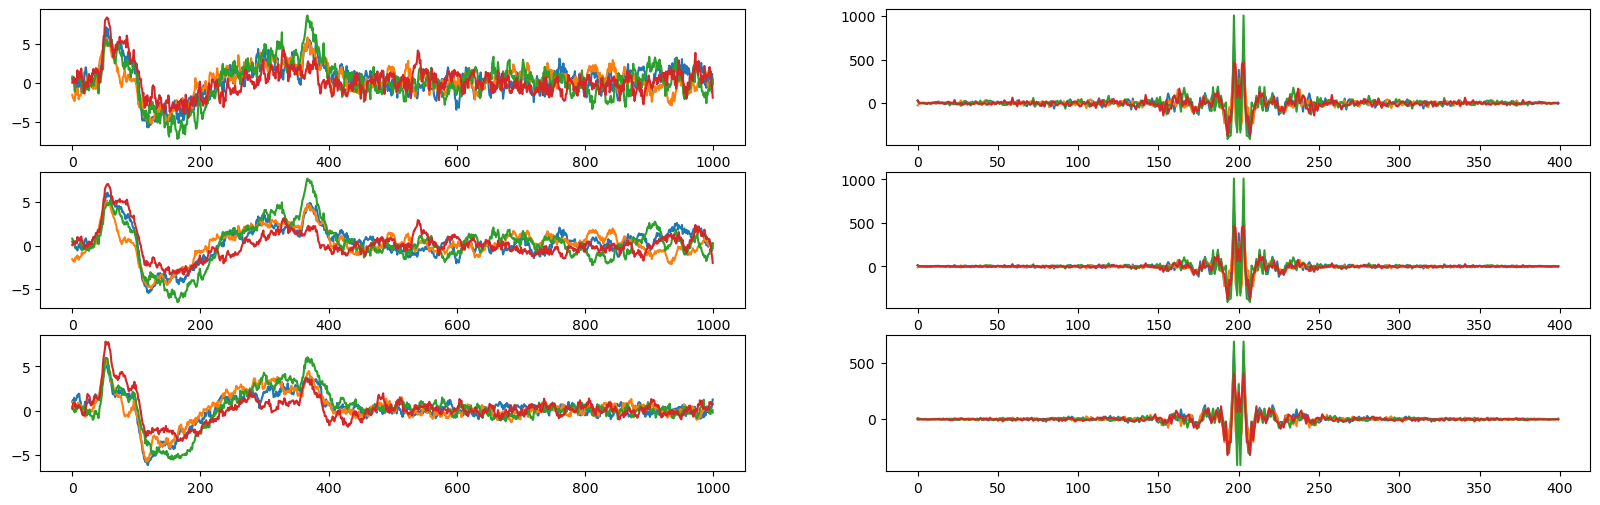

In [53]:
from scipy.fft import *

for i in range(1,3): # looping from channel 1 to 3
    res = extract_channel_mean(X_test_original[0:400],y_test[0:400], i,1) # extract channel mean from channel=i, with 1 random sample returned too show single sample shape
    res2 = extract_channel_mean(X_train_valid_original,y_train_valid, i,1)

    plt.figure(figsize=(20,6))
    plotter = lambda z, y : plt.subplot(z).plot(y)
    stemmer = lambda z, y : plt.subplot(z).stem(y)
    lower = 300
    upper = 700
    for x in res:
        plotter(321, x[0])
        plotter(322, fftshift(fft(x[0]))[lower:upper]) # Test data
        out = scale_high_freq(x[0], 0.06, 0.4)
        plotter(323, out)
        plotter(324, fftshift(fft(out))[lower:upper]) # Filtered Test Data


    for x in res2:
        plotter(325, x[0])
        plotter(326, fftshift(fft(x[0]))[lower:upper]) # Training Data
    plt.show()

In [56]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, sub_sample):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X


In [59]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid_original,y_train_valid,1,1,True)
X_test_prep = test_data_prep(X_test_original, 1) 
print(np.max(y_train_valid_prep))
print(np.min(y_train_valid_prep))

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(len(X_train_valid_prep), 1000, replace=False)
ind_train = np.array(list(set(range(len(X_train_valid_prep))).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train_useful, x_valid_useful) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train_useful, y_valid_useful) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train_useful.shape)
print('Shape of validation set:',x_valid_useful.shape)
print('Shape of training labels:',y_train_useful.shape)
print('Shape of validation labels:',y_valid_useful.shape)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_useful, 4)
y_valid = to_categorical(y_train_useful, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train_useful.reshape(x_train_useful.shape[0], x_train_useful.shape[1], x_train_useful.shape[2], 1)
x_valid = x_valid_useful.reshape(x_valid_useful.shape[0], x_valid_useful.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 1000)
Shape of X after maxpooling: (2115, 22, 1000)
Shape of X after averaging+noise and concatenating: (4230, 22, 1000)
Shape of X after subsampling and concatenating: (6345, 22, 1000)
Shape of Y: (6345,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 800)
3
0
Shape of training set: (5345, 22, 1000)
Shape of validation set: (1000, 22, 1000)
Shape of training labels: (5345,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (5345, 4)
Shape of validation labels after categorical conversion: (5345, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (5345, 22, 1000, 1)
Shape of validation set after adding width info: (1000, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 800, 1)
Shape of training set after dimension reshaping: (5345, 1000, 1, 22)
Shape of validation set after dimension reshaping: (1000

## Comparing the effects of data-preparation with no preparation  

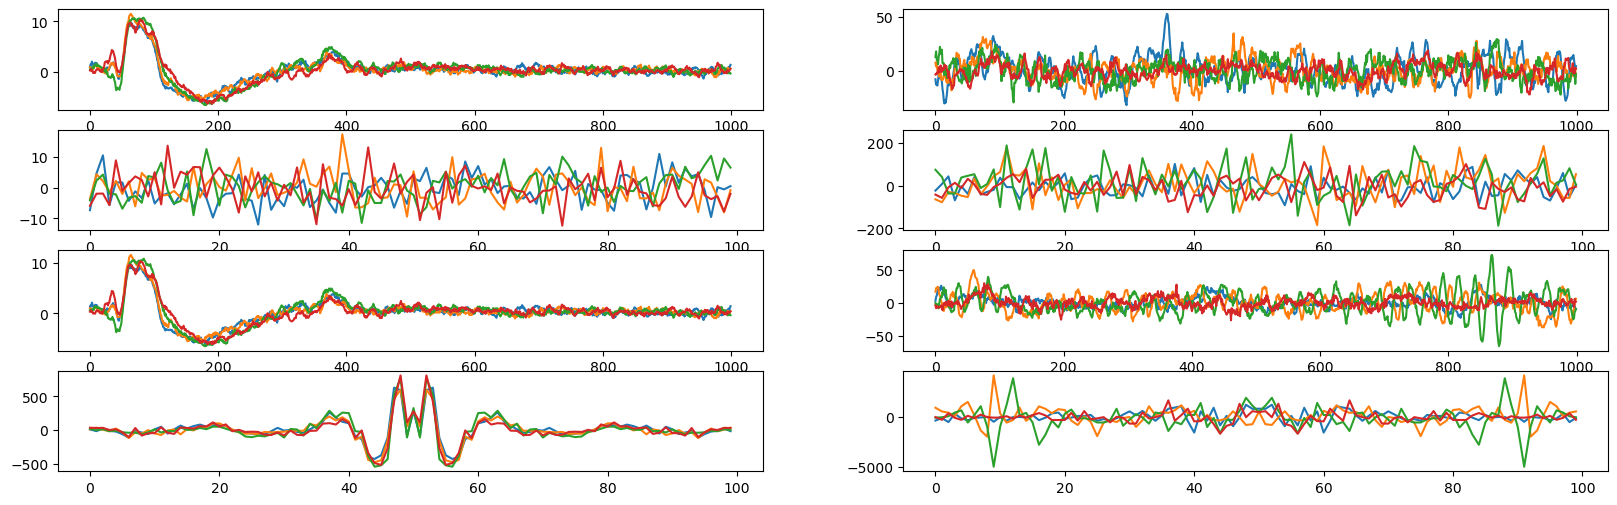

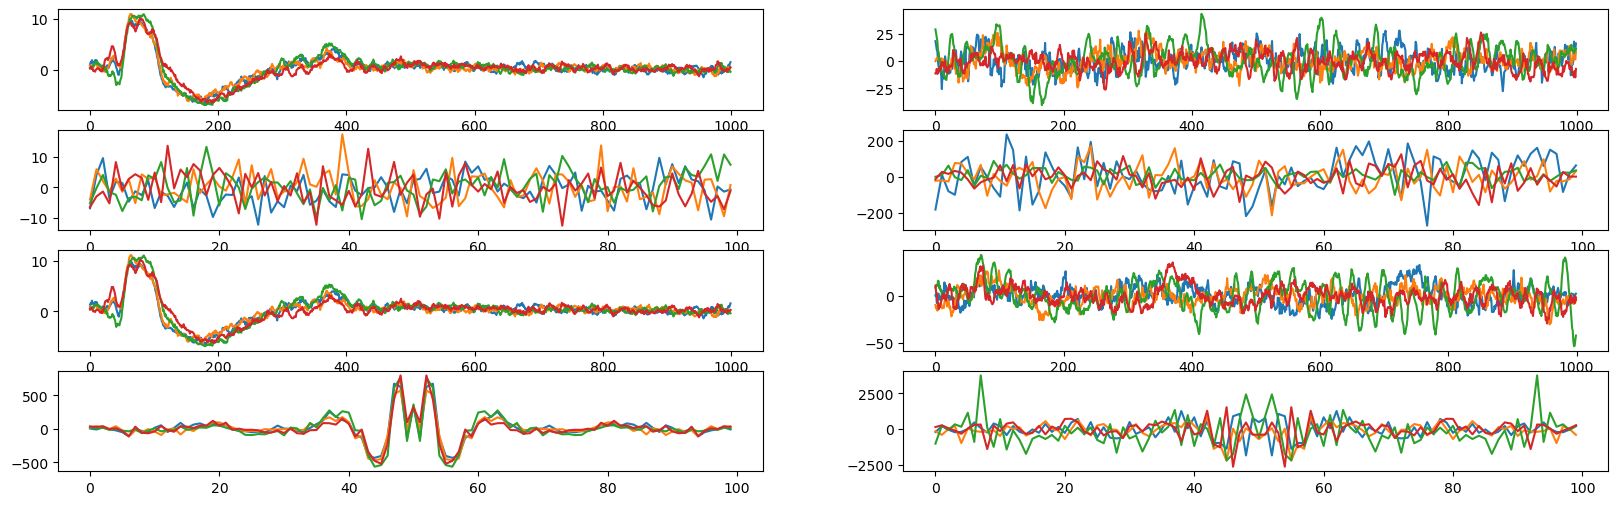

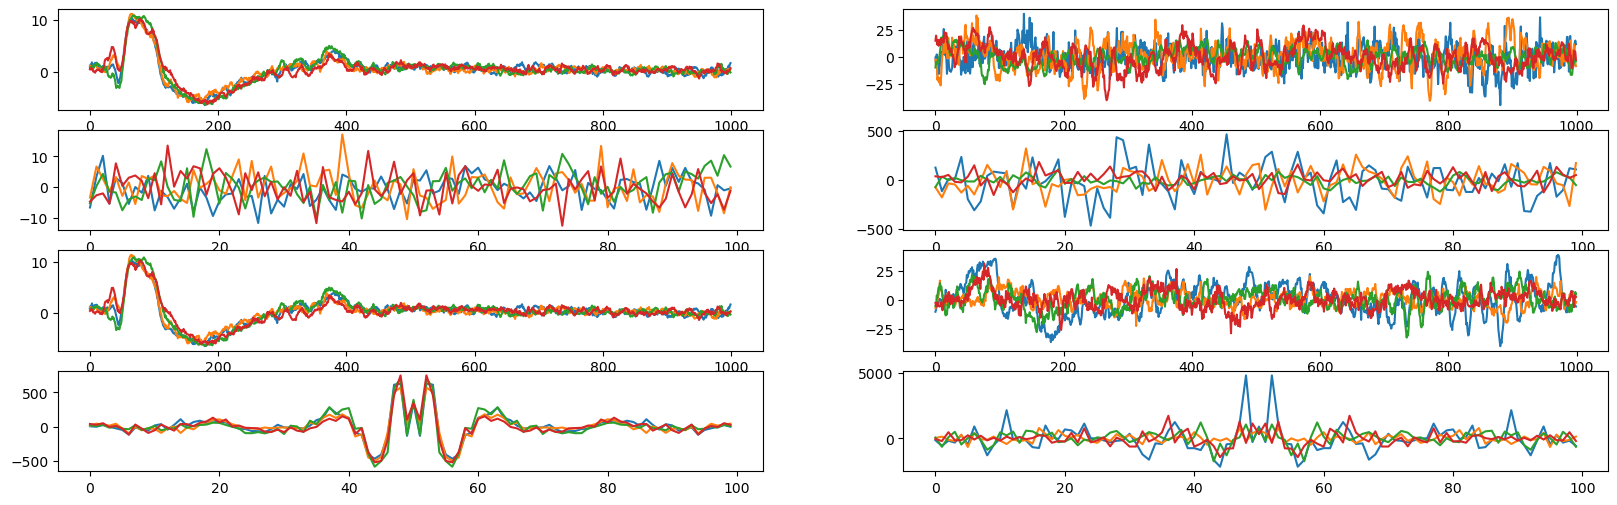

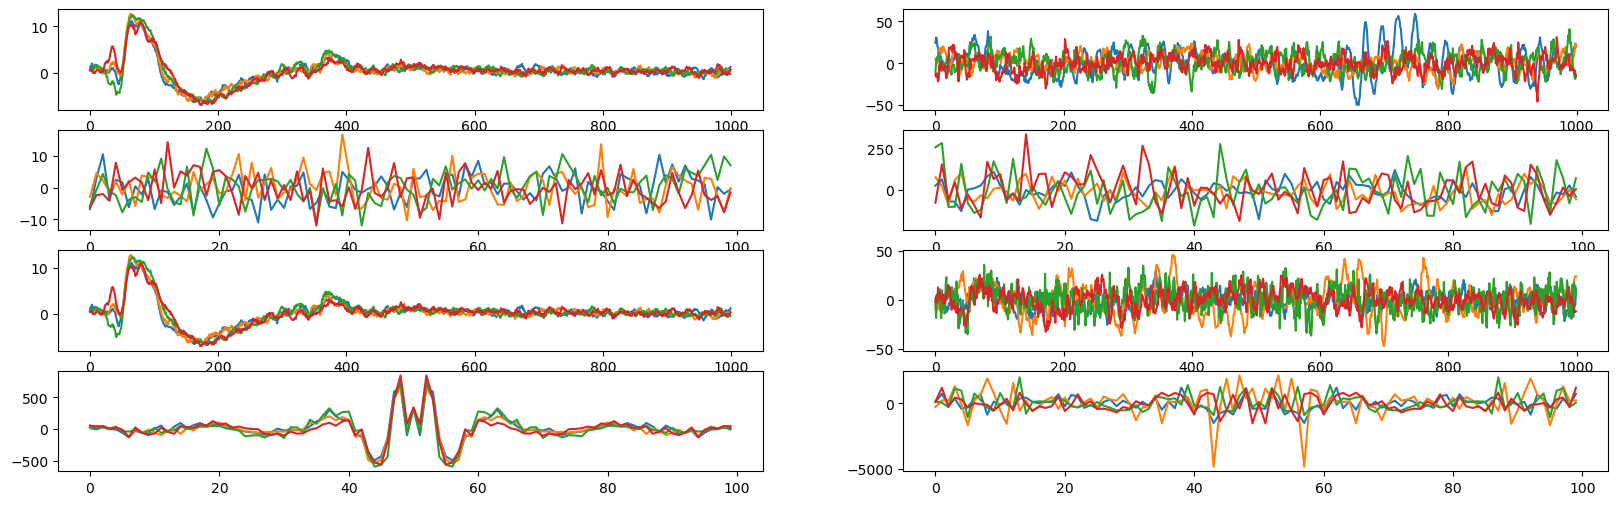

In [62]:
import scipy
from scipy.fft import *

for i in range(18,22):
    res = extract_channel_mean(x_train_useful, y_train_useful,i,1) # Processing
    plt.figure(figsize=(20,6))
    plotter = lambda z, y : plt.subplot(z).plot(y)
    stemmer = lambda z, y : plt.subplot(z).stem(y)
    lower = 150
    upper = 250
    for x in res:
        plotter(421, x[0])
        plotter(422, np.mean(x[1], axis=0))
        plotter(423, scipy.fft.fftshift(fft(x[0]))[lower:upper])
        plotter(424, scipy.fft.fftshift(fft(np.mean(x[1], axis=0)))[lower:upper])

    res = extract_channel_mean(X_train_valid_original,y_train_valid, i,1) # No pre-processing
    lower = 450
    upper = 550
    for x in res:
        plotter(425, x[0])
        plotter(426, np.mean(x[1], axis=0))
        plotter(427, fftshift(fft(x[0]))[lower:upper])
        plotter(428, fftshift(fft(np.mean(x[1], axis=0)))[lower:upper])

    plt.show()

## Comparing Cosine similarity of FFT version of signal

```
{'meta': {'fft_bound': 50, 'downsample': True},
 'channel_0': {'0_1': {'raw_cs': 0.8781113742163258,
   'fft_cs': 0.86926916623557,
   'raw_cs_rand': 0.011147212574094671,
   'fft_rand_cs': -0.0213540300730463},
  '0_2': {'raw_cs': 0.8796998788999602,
   'fft_cs': 0.8428310718522882,
   'raw_cs_rand': 0.22394902070635575,
   'fft_rand_cs': 0.124162171355048}}}
```

Explanation of the JSON:

meta contains info about whether our sample was downsampled or not (use x_train_useful for downsampled version from provided data pre-processing code.) Otherwise if testing with 

channel_x is a dictionary containing information of comparison from $x$ to other channels.

$x$_$y$ is cosine similarity from channel x to channel y.

In [69]:
from numpy import dot
from numpy.linalg import norm
from math import * 
cos_sim = lambda a,b : dot(a, b)/(norm(a)*norm(b))
import json

def cos_comp_of_fft_and_time_series(X, Y, bound=50,  downsample=False):
    def round_sig(x, sig=2):
        return round(x, sig-int(floor(log10(abs(x))))-1)

    data = {"meta":{"fft_bound":bound, "downsample":downsample}}

    for i in range(0,22):
        res = extract_channel_mean(X,Y, i,1)
        index = [[[0,1],[0,2],[0,3]],[[1,2],[1,3]],[[2,3]]]
        # print("==========================for channel = " + str(i) + "=============================")
        lower = len(res[0][0])//2 - bound
        upper = len(res[0][0])//2 + bound
        z = []
        z1 = []
        key = "channel_"+str(i)
        data[key]={}
        for a in index:
            resx = ""
        res = extract_channel_mean(X,Y, i,1)
        index = [[[0,1],[0,2],[0,3]],[[1,2],[1,3]],[[2,3]]]
        # print("==========
            for b in a:
                cs = cos_sim(np.real(fftshift(fft(res[b[0]][0]))[lower:upper]) , np.real(fftshift(fft(res[b[1]][0]))[lower:upper]))
                cs1 = cos_sim(res[b[0]][0], res[b[1]][0])
                z.append(cs)
                z1.append(cs1)
                resx = resx + str(b[0]) + "," + str(b[1]) + " -> " +str(round_sig(cs, 3)) + " & " + str(round_sig(cs1,3)) + " | " 
                rcs = cos_sim(np.real(fftshift(fft(res[b[0]][1][0]))[lower:upper]) , np.real(fftshift(fft(res[b[1]][1][0]))[lower:upper]))
                rcs1 = cos_sim(res[b[0]][1][0], res[b[1]][1][0])
                data[key][str(b[0]) + "_" + str(b[1])]  = {"raw_cs": cs, "fft_cs": cs1, "raw_cs_rand":rcs, "fft_rand_cs":rcs1}

        data[key]["raw_min"] = min(z)
        data[key]["fft_min"] = min(z1)
    return data

In [70]:
cos_comp_of_fft_and_time_series(x_train_useful, y_train_useful, bound=50, downsample=True) # after downsampleing

##


{'meta': {'fft_bound': 50, 'downsample': True},
 'channel_0': {'0_1': {'raw_cs': 0.8781113742163258,
   'fft_cs': 0.86926916623557,
   'raw_cs_rand': 0.011147212574094671,
   'fft_rand_cs': -0.0213540300730463},
  '0_2': {'raw_cs': 0.8796998788999602,
   'fft_cs': 0.8428310718522882,
   'raw_cs_rand': 0.22394902070635575,
   'fft_rand_cs': 0.124162171355048},
  '0_3': {'raw_cs': 0.5266362657047645,
   'fft_cs': 0.5388833098223014,
   'raw_cs_rand': -0.031210150937456035,
   'fft_rand_cs': -0.08748665409824423},
  '1_2': {'raw_cs': 0.8133630088469801,
   'fft_cs': 0.8306888883747463,
   'raw_cs_rand': -0.24213706184348693,
   'fft_rand_cs': -0.10628097773333264},
  '1_3': {'raw_cs': 0.6382307513191311,
   'fft_cs': 0.5816199204267062,
   'raw_cs_rand': 0.12457674480931562,
   'fft_rand_cs': 0.1158062616008986},
  '2_3': {'raw_cs': 0.5054772761420134,
   'fft_cs': 0.5572339650694927,
   'raw_cs_rand': 0.0948810146588814,
   'fft_rand_cs': 0.09175268701594091},
  'raw_min': 0.505477276142

In [79]:
cos_comp_of_fft_and_time_series(X_train_valid_original, y_train_valid, bound=50, downsample=False) # No downsampling

{'meta': {'fft_bound': 50, 'downsample': False},
 'channel_0': {'0_1': {'raw_cs': 0.8748786127338111,
   'fft_cs': 0.8740160057429237,
   'raw_cs_rand': 0.06339801126196218,
   'fft_rand_cs': -0.005336443234538466},
  '0_2': {'raw_cs': 0.8701318301245261,
   'fft_cs': 0.8404031094896071,
   'raw_cs_rand': -0.03181045905136406,
   'fft_rand_cs': -0.0256137059002419},
  '0_3': {'raw_cs': 0.5307247003518907,
   'fft_cs': 0.5296948335627223,
   'raw_cs_rand': 0.13415078222887464,
   'fft_rand_cs': 0.0542711116872384},
  '1_2': {'raw_cs': 0.8071609032882266,
   'fft_cs': 0.8269869693720093,
   'raw_cs_rand': 0.023001788248139823,
   'fft_rand_cs': 0.13546697518200307},
  '1_3': {'raw_cs': 0.6614342222135577,
   'fft_cs': 0.5848496760885923,
   'raw_cs_rand': 0.32606593818277557,
   'fft_rand_cs': 0.05800339170293784},
  '2_3': {'raw_cs': 0.5367609295472207,
   'fft_cs': 0.5638576487829718,
   'raw_cs_rand': 0.12691468286899946,
   'fft_rand_cs': -0.01340136971638071},
  'raw_min': 0.5307247

In [80]:
#importing the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import load_arrow_head  # Example dataset

# Load a sample time series dataset (ArrowHead dataset for demonstration)
# X, y = load_arrow_head(return_type="numpy3D")50
# print(X.shape)
# print(y.shape)
# Split the dat
# aset into training and testing sets


xtt = x_train
xtt1 = x_test
ytt = y_train
ytt1 = y_test

xtt = np.squeeze(xtt, axis=2)
xtt = np.swapaxes(xtt, 1,2)

xtt1 = np.squeeze(xtt1, axis=2)
xtt1 = np.swapaxes(xtt1, 1,2)

print(xtt.shape)
print(xtt1.shape)

(5345, 22, 1000)
(443, 22, 800)


In [ ]:
X_train, Y_train = xtt, ytt
X_test, Y_test = xtt1, ytt1

# Create and fit the ROCKET classifier
clf = RocketClassifier(num_kernels=500)
clf.fit(X_train, Y_train)


RocketClassifier(num_kernels=500)

In [ ]:
clf.save("rocket")

<zipfile.ZipFile filename='rocket.zip' mode='r'>

In [ ]:
# Generate predictions on the test set
Y_pred = clf.predict(xtt1)
print(Y_pred)
# Create a classification report
class_report = classification_report(ytt1, Y_pred)

# Print the classification report
print("Classification Report:\n", class_report)

       0    1    2    3
0    0.0  0.0  0.0  1.0
1    0.0  0.0  1.0  0.0
2    0.0  0.0  0.0  0.0
3    0.0  0.0  1.0  0.0
4    0.0  0.0  0.0  0.0
..   ...  ...  ...  ...
438  0.0  0.0  0.0  0.0
439  0.0  0.0  0.0  0.0
440  0.0  0.0  0.0  1.0
441  0.0  0.0  0.0  1.0
442  0.0  0.0  0.0  0.0

[443 rows x 4 columns]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.22      0.31       111
           1       0.40      0.17      0.24       127
           2       0.36      0.28      0.32        96
           3       0.56      0.35      0.43       109

   micro avg       0.46      0.25      0.32       443
   macro avg       0.46      0.25      0.32       443
weighted avg       0.46      0.25      0.32       443
 samples avg       0.22      0.25      0.23       443



/home/seantang001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf.score(xtt, ytt)

0.4974530831099196

In [ ]:
clf.score(xtt1, ytt1)

0.20090293453724606